## Importing needed packages

In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from scipy.stats import norm
from DataHandling import *
from ModelClasses import *
import matplotlib.pyplot as plt

## Defining Input Parameters

In [2]:
# Define number of hours as length of demand
N_Hours = hours_per_year

# Define number of generators as length of CapCost
N_Cap = len(CapCost)

# Define number of storage as length of StorCost
N_Stor = len(StorCost)

# Define number of scenarios as number of columns in ProdFacWind
N_Scen = scenarios_per_year * len(years)

# Define epsilon
epsilon = 0

#Define delta
delta = 0.8

BigM = 1000000


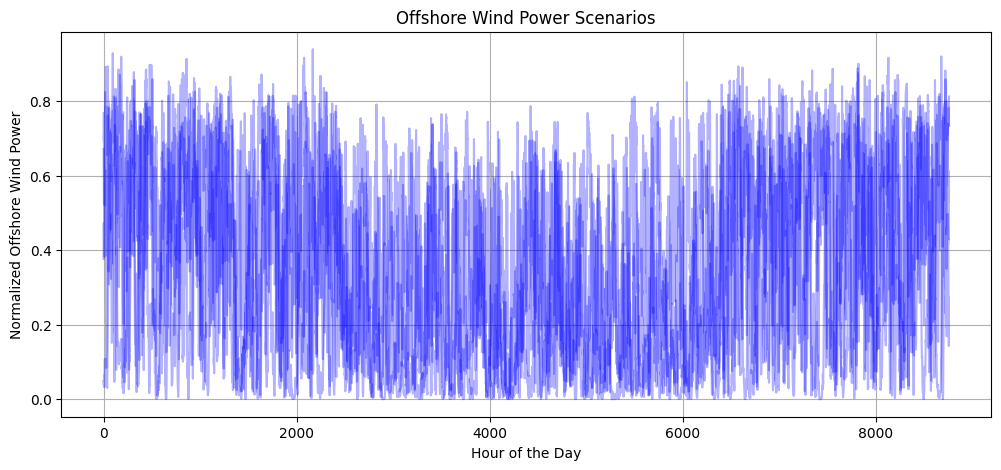

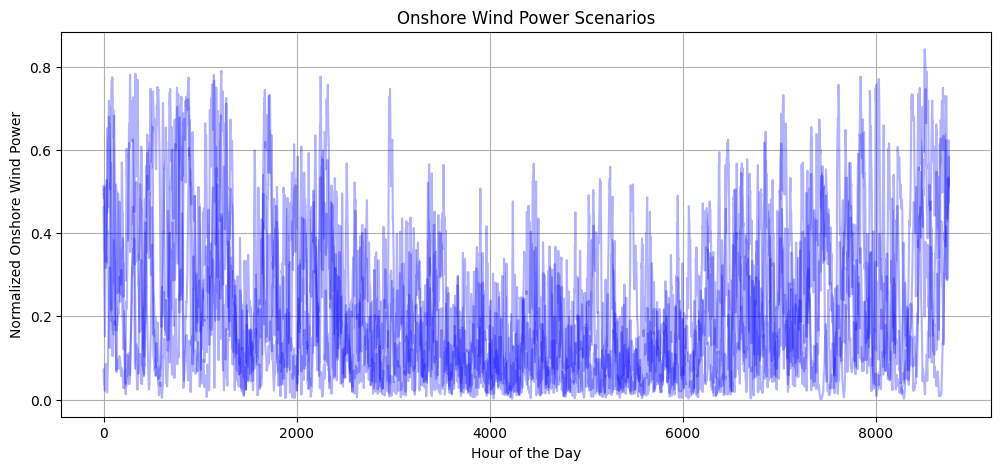

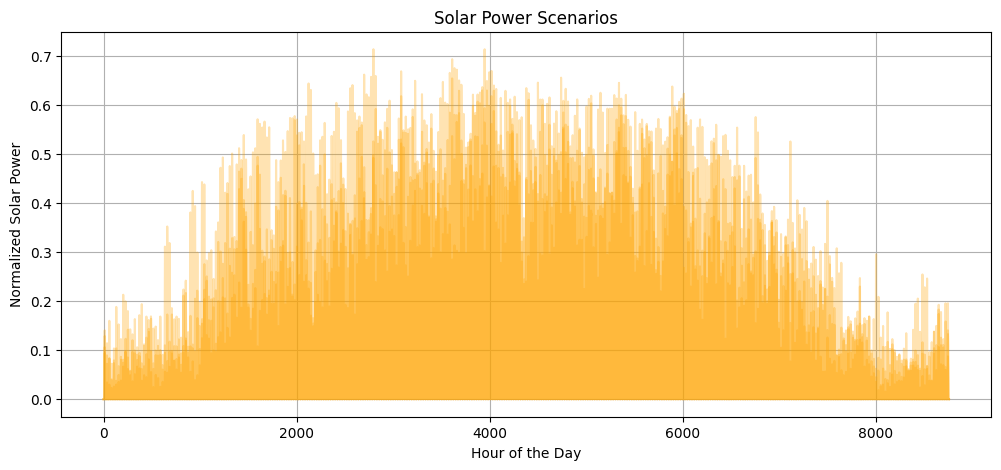

In [3]:


# Plot offshore Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen): 
    plt.plot(range(N_Hours), Offwind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Offshore Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Offshore Wind Power")
plt.grid(True)
plt.show()

# Plot onshore Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  
    plt.plot(range(N_Hours), Onwind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Onshore Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Onshore Wind Power")
plt.grid(True)
plt.show()

# Plot Solar Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen): 
    plt.plot(range(N_Hours), Solar_scenarios[:, scenario], alpha=0.3, color='orange')
plt.title("Solar Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Solar Power")
plt.grid(True)
plt.show()

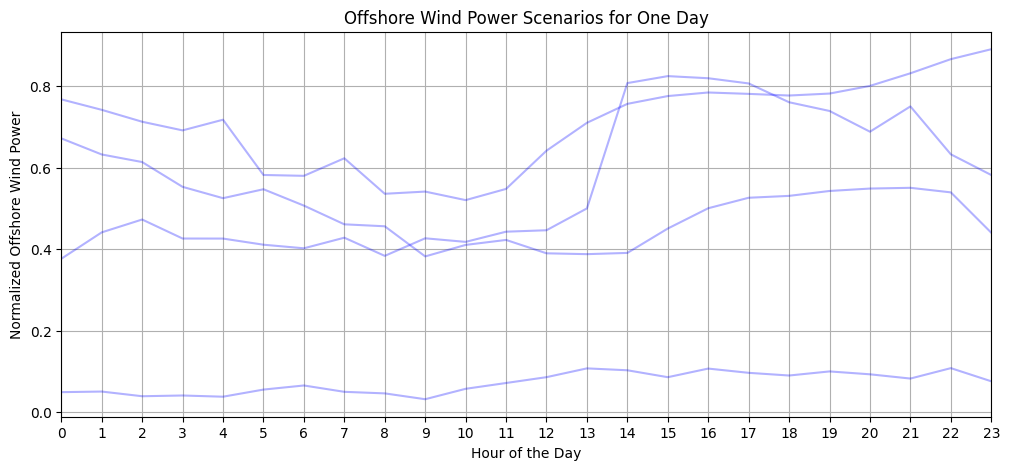

In [4]:
#Plot one day of offshore wind scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(24), Offwind_scenarios[0:24, scenario], alpha=0.3, color='blue')
plt.title("Offshore Wind Power Scenarios for One Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Offshore Wind Power")
plt.grid(True)
plt.xlim(0, 23)  # Limit x-axis to 24 hours
plt.xticks(range(24))  # Set x-ticks to show each hour
plt.show()

## Creating Data and Parameter Objects

In [5]:
ParametersObj = Parameters(epsilon, delta, N_Hours, N_Cap, N_Stor, N_Scen, BigM)
DataObj = InputData(CapCost, OpCost, TechInfo, StorCost, CapLim,CapExi,CapOut,Demand,EtaCh,EtaDis,StorExi, Offwind_scenarios, Onwind_scenarios, Solar_scenarios, StorLim)


## Execute the capacity investment model

In [6]:
CapacityProblem = CapacityProblem(ParametersObj, DataObj)
#CapacityProblem._results()
#CapacityProblem._extract_results()

ResultsCapacity = CapacityProblem.res.CapNew
ResultsStorage = CapacityProblem.res.CapStor
#ResultsViolations = CapacityProblem.res.Violation_Scenarios

for scenario_name, df in CapacityProblem.res.EGen_Scenarios.items():
    df.to_csv(f"{scenario_name}.csv", index=False)  # Save each scenario as a CSV file
    print(f"Saved {scenario_name}.csv")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-14
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 876003 rows, 630738 columns and 2835839 nonzeros
Model fingerprint: 0x09e1c9b2
Variable types: 630734 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+06]
  Objective range  [6e+03, 9e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 4e+05]
Presolve removed 282718 rows and 72463 columns
Presolve time: 3.82s
Presolved: 593285 rows, 558275 columns, 1987752 nonzeros
Variable types: 558275 continuous, 0 integer (0 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.82s

Barrier stat

## Create Market Clearing class

In [7]:
class DayAheadProblem():
    def __init__(self, ParametersObj, DataObj, GenerationCapacity, StorageCapacity, Model_results = 1, Guroby_results = 1):
        self.P = ParametersObj # Parameters
        self.D = DataObj # Data
        self.Model_results = Model_results
        self.Guroby_results = Guroby_results
        self.GenCap = GenerationCapacity
        self.StorCap = StorageCapacity
        self.var = Expando()  # Variables
        self.con = Expando()  # Constraints
        self.res = Expando()  # Results
        self._build_model() 


    def _build_variables(self):
        # Create the variables
        self.var.EGen = self.m.addMVar((self.P.N_Cap, self.P.N_Hours, self.P.N_Scen), lb=0)  # Variable for generation for each scenario, technology, and hour
        self.var.SOC = self.m.addMVar((self.P.N_Stor, self.P.N_Hours, self.P.N_Scen), lb=0)  # Variable for state of charge for each scenario, storage technology, and hour
        self.var.EChar = self.m.addMVar((self.P.N_Stor, self.P.N_Hours, self.P.N_Scen), lb=0)  # Variable for energy charge for each scenario, storage technology, and hour
        self.var.EDis = self.m.addMVar((self.P.N_Stor, self.P.N_Hours, self.P.N_Scen), lb=0)  # Variable for energy discharge for each scenario, storage technology, and hour

    def _build_constraints(self):

        G, H, S, U = self.P.N_Cap, self.P.N_Hours, self.P.N_Scen, self.P.N_Stor
    
        # Generation capacity constraint
        CapTotal = self.GenCap.reshape((G, 1, 1)) + self.D.CapExi.reshape((G, 1, 1)) + self.D.CapOut.reshape((G, 1, 1))


        Techs = self.D.TechInfo['Technology'].values
        OffshoreMask = (Techs == 'Wind Offshore')
        OnshoreMask = (Techs == 'Wind Onshore')
        SolarMask = (Techs == 'PV')
        ConvMask = ~(OffshoreMask | OnshoreMask | SolarMask)

        if OffshoreMask.any():
            self.con.ProdLim_Offshore = self.m.addConstr(
                self.var.EGen[OffshoreMask, :, :] <= CapTotal[OffshoreMask, :, :] * self.D.Offwind_scenarios[None, :, :],
                name='ProdLimit_Offshore'
            )
        if OnshoreMask.any():
            self.con.ProdLim_Onshore = self.m.addConstr(
                self.var.EGen[OnshoreMask, :, :] <= CapTotal[OnshoreMask, :, :] * self.D.Onwind_scenarios[None, :, :],
                name='ProdLimit_Onshore'
            )
        if SolarMask.any():
            self.con.ProdLim_Solar = self.m.addConstr(
                self.var.EGen[SolarMask, :, :] <= CapTotal[SolarMask, :, :] * self.D.Solar_scenarios[None, :, :],
                name='ProdLimit_Solar'
            )
        if ConvMask.any():
            self.con.ProdLim_Conv = self.m.addConstr(
                self.var.EGen[ConvMask, :, :] <= CapTotal[ConvMask, :, :],
                name='ProdLimit_Conventional'
            )

        # Energy Balance constraint
        EGen_sum = self.var.EGen.sum(axis=0)    # shape (H, S)
        EDis_sum = self.var.EDis.sum(axis=0)    # shape (H, S)
        EChar_sum = self.var.EChar.sum(axis=0)  # shape (H, S)
        Demand_scaled = self.D.Dem[:H, None]  # shape (H, 1), broadcast to (H, S)

        self.con.Balance = self.m.addConstr(EGen_sum + EDis_sum == Demand_scaled + EChar_sum, name='EnergyBalance')


        #Defining SOC, Charge and Discharge for each scenario and each hour >0
        SOC = self.var.SOC
        EChar = self.var.EChar
        EDis = self.var.EDis
        SOC_prev = SOC[:, :-1, :]  # (U, H-1, S)
        EChar_prev = EChar[:, :-1, :]
        EDis_prev = EDis[:, :-1, :]
        SOC_curr = SOC[:, 1:, :]

        # Defining SOC as results of previous hours
        self.con.SOC_Update = self.m.addConstr(SOC_curr == SOC_prev + EChar_prev - EDis_prev, name='SOC_Update')

        # Defining Initial SOC
        self.con.SOC0 = self.m.addConstr(SOC[:, 0, :] == self.D.StorExi[:, None] + self.StorCap[:,None], name='SOC_Initial')

        # Limit SOC by existing storage capacity and new storage capacity
        self.con.SOCLim = self.m.addConstr(
            SOC <= self.StorCap[:, None, None] + self.D.StorExi[:, None, None],
            name='StorageCapLimit'
        )

        # Limit charge by existing storage capacity and new storage capacity - SOC
        self.con.ECharLim = self.m.addConstr(
            EChar <= self.StorCap[:, None, None] + self.D.StorExi[:, None, None] - SOC,
            name='ECharLimit'
        )
        # Limit Discharge by SOC
        self.con.EDisLim = self.m.addConstr(
            EDis <= SOC,
            name='EDisLimit'
        )

        # Indices of Lignite and Hard Coal
        lignite_index = list(self.D.TechInfo['Technology']).index('Lignite')
        hard_coal_index = list(self.D.TechInfo['Technology']).index('Hard Coal')

        # Ramp rates for Hard Coal and Lignite
        ramp_rates = {
            lignite_index: 0.1,  # 7% of capacity
            hard_coal_index: 0.1  # 8% of capacity
        }

        # --- Ramping Constraints ---
        for g, ramp_rate in ramp_rates.items():
            for s in range(S):
                for t in range(1, H):  # Start from 1 to prevent indexing error
                    # Up-ramping constraint
                    self.m.addConstr(
                        self.var.EGen[g, t, s] - self.var.EGen[g, t - 1, s] <= ramp_rate * CapTotal[g, 0, 0],
                        name=f"Ramping_Up_{self.D.TechInfo['Technology'][g]}_S{s}_H{t}"
                    )

                    # Down-ramping constraint
                    self.m.addConstr(
                        self.var.EGen[g, t - 1, s] - self.var.EGen[g, t, s] <= ramp_rate * CapTotal[g, 0, 0],
                        name=f"Ramping_Down_{self.D.TechInfo['Technology'][g]}_S{s}_H{t}"
                    )

        
    
    def _build_objective(self):

        # Vectorized operational cost for generation multiplied by generation
        op_cost = (self.var.EGen * self.D.OpCost[:, None, None]).sum() 

        # Set objective, minimizing total costs
        self.m.setObjective( op_cost, GRB.MINIMIZE)


    def _display_guropby_results(self):
        self.m.setParam('OutputFlag', self.Guroby_results)

    
    def _build_model(self):
        self.m = gp.Model('CapacityProblem')
        self._build_variables()
        self._build_constraints()
        self._build_objective()
        self._display_guropby_results()
        self.m.write("CapacityProblem.lp")
        self.m.optimize()
        self._results()
        if self.Model_results == 1:
            self._extract_results()
            
    def _extract_energy_balance_duals(self):
        # Ensure the model is optimized
        if self.m.status == GRB.OPTIMAL:
            print("Model solved successfully, extracting dual values...")

            # Initialize an empty list to collect duals
            dual_values = []

            # Loop through hours and scenarios to collect dual values
            for h in range(self.P.N_Hours):
                hour_values = []
                for s in range(self.P.N_Scen):
                    # Access the individual constraint
                    constraint = self.con.Balance[h, s]
                    # Extract the dual value (shadow price)
                    hour_values.append(constraint.Pi/1000)
                dual_values.append(hour_values)

            # Convert to a NumPy array and reshape
            dual_array = np.array(dual_values)

            # Store as DataFrame with labels for clarity
            self.res.DA_Prices = pd.DataFrame(
                dual_array,
                columns=[f"Scenario_{s}" for s in range(self.P.N_Scen)],
                index=[f"Hour_{h}" for h in range(self.P.N_Hours)]
            )

            print("Energy Balance Dual values (Day Ahead Prices) extracted successfully.")
        else:
            print("Model did not solve optimally; cannot extract dual values.")

    
    def _results(self):
        self.res.obj = self.m.objVal
        self._extract_energy_balance_duals()

        # Extract results
        self.res.EGen = self.var.EGen.X
        self.res.SOC = self.var.SOC.X
        self.res.EChar = self.var.EChar.X
        self.res.EDis = self.var.EDis.X
        # Calculate RES Share for each scenario
        self.res.RESShare = np.zeros((self.P.N_Scen, 1))
        for s in range(self.P.N_Scen):
            self.res.RESShare[s] =   np.sum(self.res.EGen[:, :, s][self.D.TechInfo['Type'] == 'RES'])/np.sum(self.D.Dem)
         
    
        # Store results in one dataframe
        self.res.DA_EGen_Scenarios = {}

        for s in range(self.P.N_Scen):
            # Extract data for scenario `s`
            e_gen_scenario = self.res.EGen[:, :, s].T  
            soc_scenario = self.res.SOC[:, :, s].T  
            echar_scenario = self.res.EChar[:, :, s].T  
            edis_scenario = self.res.EDis[:, :, s].T  
            DA_prices = self.res.DA_Prices.iloc[:, s].values  # Extract Day Ahead Prices for scenario `s`

            # Extract Wind and Solar Production Factors
            Offwind_scenarios = self.D.Offwind_scenarios[:, s]  
            Onwind_scenarios = self.D.Onwind_scenarios[:, s]  
            Solar_scenarios = self.D.Solar_scenarios[:, s]  

            # Convert to DataFrames
            df_scenario = pd.DataFrame(e_gen_scenario, columns=['Offshore', 'Onshore', 'Biomass', 'Lignite', 'Hard Coal', 'Gas', 'Hydrogren', 'Nuclear', 'Solar PV', 'Hydro', 'Other RES', 'Other Conventional'])
            df_soc = pd.DataFrame(soc_scenario, columns=['Battery_SOC', 'PumpedHydro_SOC'])
            df_echar = pd.DataFrame(echar_scenario, columns=['Battery_Charge', 'PumpedHydro_Charge'])
            df_edis = pd.DataFrame(edis_scenario, columns=['Battery_Discharge', 'PumpedHydro_Discharge'])
            df_demand = pd.DataFrame({'Demand': self.D.Dem})
            df_DA = pd.DataFrame({'DA_Prices': DA_prices})

            # Add Wind & Solar Production Factors
            df_prod_factors = pd.DataFrame({'OffWind': Offwind_scenarios, 'OnWind': Onwind_scenarios, 'Solar': Solar_scenarios})

            # Add Hour column
            df_scenario['Hour'] = list(range(self.P.N_Hours))

            # Merge all DataFrames
            df_complete = pd.concat([df_scenario, df_soc, df_echar, df_edis, df_demand,df_DA, df_prod_factors], axis=1)

            #Reorder columns
            df_complete = df_complete[['Hour', 'Offshore', 'Onshore', 'Biomass', 'Lignite', 'Hard Coal', 'Gas', 'Hydrogren', 'Nuclear', 'Solar PV', 'Hydro', 'Other RES', 'Other Conventional',
                                    'Battery_SOC', 'PumpedHydro_SOC',
                                    'Battery_Charge', 'PumpedHydro_Charge',
                                    'Battery_Discharge', 'PumpedHydro_Discharge',
                                    'Demand', 'OffWind','OnWind', 'Solar', 'DA_Prices']]

            # Store in dictionary
            self.res.DA_EGen_Scenarios[f"DA_Scenario_{s}"] = df_complete
        
        # Initialize the DataFrame to store results
        technology_names = self.D.TechInfo['Technology'].values
        scenario_names = [f"Scenario_{s}" for s in range(self.P.N_Scen)]

        # Create an empty DataFrame with technologies as index and scenarios as columns
        self.res.CapturePrices = pd.DataFrame(index=technology_names, columns=scenario_names)

        # Loop through each scenario and technology to calculate capture prices
        for s in range(self.P.N_Scen):
            for g, tech_name in enumerate(technology_names):
                # Avoid division by zero
                total_generation = np.sum(self.res.EGen[g, :, s])
                if total_generation > 0:
                    capture_price = np.sum(self.res.EGen[g, :, s] * self.res.DA_Prices.iloc[:, s].values) / total_generation
                else:
                    capture_price = 0
                
                # Store in the DataFrame
                self.res.CapturePrices.loc[tech_name, f"Scenario_{s}"] = capture_price

    def _extract_results(self):
        # Display the objective value
        print('Objective value: ', self.m.objVal)
        
        # # Display the new capacity for each type of generator technology
        # print('New capacity for each type of generator technology: ', self.res.CapNew)
        
        # #Display new storage capacity for each type of storage technology
        # print('New storage capacity for each type of storage technology: ', self.res.CapStor)

        # # Display RES Share for each scenario
        # print('RES Share for each scenario: ', self.res.RESShare)

         # Print constraint info
        # print(f"Total number of constraints: {self.res.TotalConstraints}")
        # print(f"Number of active (binding) constraints: {self.res.ActiveConstraints}")


In [8]:
ResultsCapacity = np.array(CapacityProblem.res.CapNew['CapNew[MW]'])
ResultsStorage = np.array(CapacityProblem.res.CapStor['CapStor[MWh]'])

In [9]:
DayAheadProblem = DayAheadProblem(ParametersObj, DataObj, ResultsCapacity, ResultsStorage)

DayAheadPrices = DayAheadProblem.res.DA_Prices
CapturePrices = DayAheadProblem.res.CapturePrices

for scenario_name, df in DayAheadProblem.res.DA_EGen_Scenarios.items():
    df.to_csv(f"{scenario_name}.csv", index=False)  # Save each scenario as a CSV file
    print(f"Saved {scenario_name}.csv")

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 875984 rows, 630720 columns and 1892104 nonzeros
Model fingerprint: 0xa55351b7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+04, 4e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-04, 1e+02]
Presolve removed 616724 rows and 231298 columns
Presolve time: 1.63s
Presolved: 259260 rows, 469494 columns, 1268228 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.42s

Barrier statistics:
 AA' NZ     : 1.457e+06
 Factor NZ  : 3.579e+06 (roughly 300 MB of memory)
 Factor Ops : 5.270e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal        

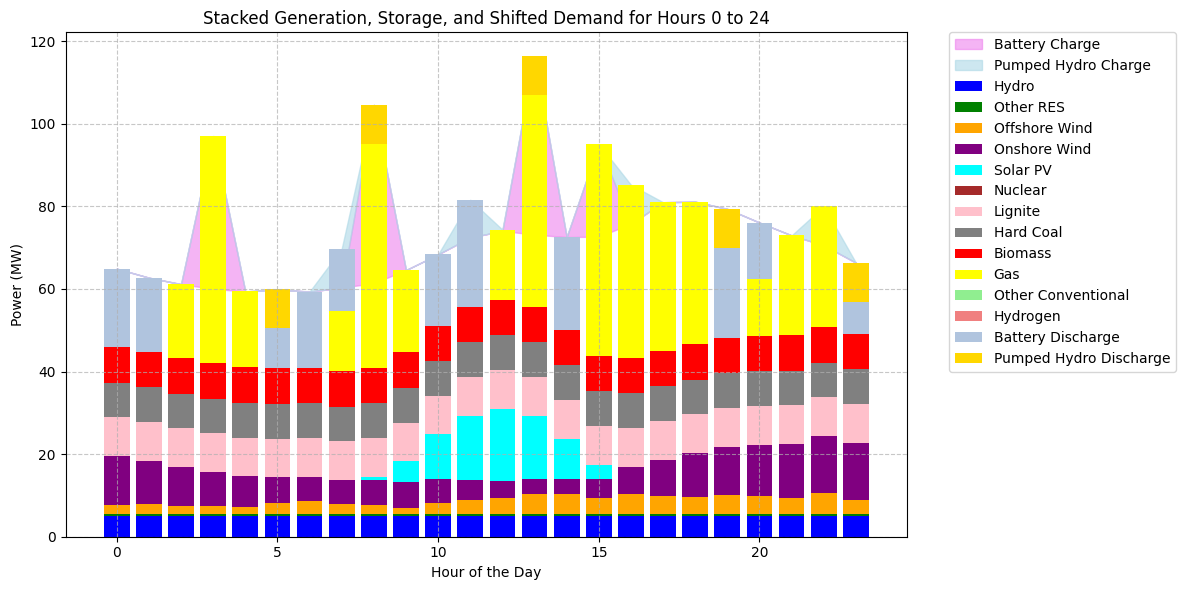

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Select the hours to be plotted
start_hour = 0
end_hour = 24
one_day_data = DayAheadProblem.res.DA_EGen_Scenarios['DA_Scenario_0'].query(f"Hour >= {start_hour} & Hour < {end_hour}")

# Prepare the data
hours = one_day_data['Hour']

# Generation and discharge sources
generation_sources = {
    'Hydro': one_day_data['Hydro'],
    'Other RES': one_day_data['Other RES'],
    'Offshore Wind': one_day_data['Offshore'],
    'Onshore Wind': one_day_data['Onshore'],
    'Solar PV': one_day_data['Solar PV'],
    'Nuclear': one_day_data['Nuclear'],
    'Lignite': one_day_data['Lignite'],
    'Hard Coal': one_day_data['Hard Coal'],
    'Biomass': one_day_data['Biomass'],
    'Gas': one_day_data['Gas'],
    'Other Conventional': one_day_data['Other Conventional'],
    'Hydrogen': one_day_data['Hydrogren'],
    'Battery Discharge': one_day_data['Battery_Discharge'],
    'Pumped Hydro Discharge': one_day_data['PumpedHydro_Discharge']
}

# Colors for generation types
gen_colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'brown', 'pink', 
              'gray', 'red', 'yellow', 'lightgreen', 'lightcoral', 'lightsteelblue', 'gold']



plt.figure(figsize=(12, 6))

# Check if there is any battery or hydro charge
if (one_day_data['Battery_Charge'].sum() == 0) and (one_day_data['PumpedHydro_Charge'].sum() == 0):
    # If there is no charge, show the original demand line
    plt.plot(one_day_data['Hour'], one_day_data['Demand'], label='Demand', color='red', linestyle='--')
else:
    # If there is charging, the demand line is hidden (visually replaced by stacked charge)
    plt.fill_between(one_day_data['Hour'],
                     one_day_data['Demand'],
                     one_day_data['Demand'] + one_day_data['Battery_Charge'],
                     label='Battery Charge', color='violet', alpha=0.6)

    plt.fill_between(one_day_data['Hour'],
                     one_day_data['Demand'] + one_day_data['Battery_Charge'],
                     one_day_data['Demand'] + one_day_data['Battery_Charge'] + one_day_data['PumpedHydro_Charge'],
                     label='Pumped Hydro Charge', color='lightblue', alpha=0.6)

# Plot the generation sources as a stacked bar chart
bottom_stack = np.zeros(len(hours))

for idx, (label, data) in enumerate(generation_sources.items()):
    plt.bar(hours, data, bottom=bottom_stack, label=label, color=gen_colors[idx])
    bottom_stack += data  # Update the bottom for the next layer

# Final touches
plt.title(f"Stacked Generation, Storage, and Shifted Demand for Hours {start_hour} to {end_hour}")
plt.xlabel("Hour of the Day")
plt.ylabel("Power (MW)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


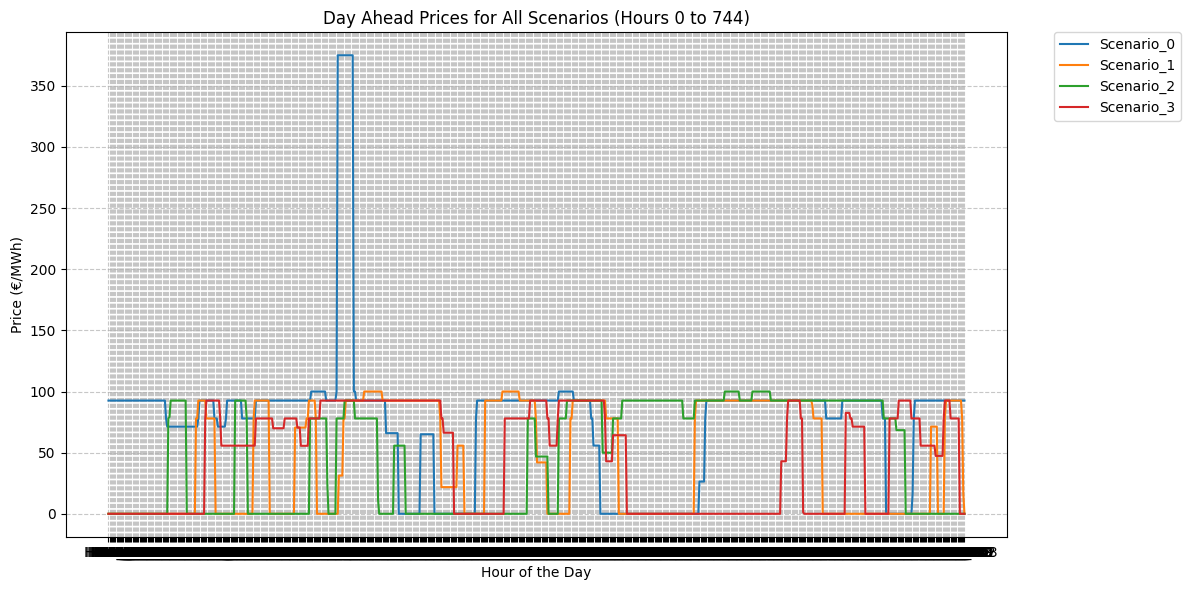

In [11]:
import matplotlib.pyplot as plt

# Choose the hour range to plot
start_hour = 0
end_hour = 24*31

# Extract the Day Ahead Prices DataFrame
prices_data = DayAheadProblem.res.DA_Prices.iloc[start_hour:end_hour]

# Plot settings
plt.figure(figsize=(12, 6))

# Plot each scenario with a different color
for scenario in prices_data.columns:
    plt.plot(prices_data.index, prices_data[scenario], label=scenario)

# Plot formatting
plt.title(f"Day Ahead Prices for All Scenarios (Hours {start_hour} to {end_hour})")
plt.xlabel("Hour of the Day")
plt.ylabel("Price (€/MWh)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
